In [1]:
import itertools
import numpy as np
import pandas as pd 
from numbers import Number
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [9]:
gross = pd.read_csv('Data/bom.movie_gross.csv')

tmdb = pd.read_csv('Data/tmdb.movies.csv')

budget = pd.read_csv('Data/tn.movie_budgets.csv')

movie_info = pd.read_csv('Data/rt.movie_info.tsv', sep='\t')

reviews = pd.read_csv('Data/rt.reviews.tsv', sep='\t', encoding='windows-1252')

In [30]:
gross['foreign_gross'].fillna(0, inplace = True)
gross['domestic_gross'].fillna(0, inplace = True)
gross['studio'].fillna('N/A', inplace = True)
gross

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
...,...,...,...,...,...
3382,The Quake,Magn.,6200.0,0,2018
3383,Edward II (2018 re-release),FM,4800.0,0,2018
3384,El Pacto,Sony,2500.0,0,2018
3385,The Swan,Synergetic,2400.0,0,2018


In [22]:
tmbd

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
...,...,...,...,...,...,...,...,...,...,...
26512,26512,"[27, 18]",488143,en,Laboratory Conditions,0.600,2018-10-13,Laboratory Conditions,0.0,1
26513,26513,"[18, 53]",485975,en,_EXHIBIT_84xxx_,0.600,2018-05-01,_EXHIBIT_84xxx_,0.0,1
26514,26514,"[14, 28, 12]",381231,en,The Last One,0.600,2018-10-01,The Last One,0.0,1
26515,26515,"[10751, 12, 28]",366854,en,Trailer Made,0.600,2018-06-22,Trailer Made,0.0,1


In [29]:

movie_info.fillna('N/A', inplace = True)
movie_info.isna().sum()

id              0
synopsis        0
rating          0
genre           0
director        0
writer          0
theater_date    0
dvd_date        0
currency        0
box_office      0
runtime         0
studio          0
dtype: int64

In [54]:
budget[budget.columns[3:]] = budget[budget.columns[3:]].replace('[\$,]', '', regex=True).astype(int)


budget['domesticgross_over_budget'] = (budget.domestic_gross)/(budget.production_budget)
budget['wwgross_over_budget'] = (budget.worldwide_gross)/(budget.production_budget)

budget.drop(budget[(budget['domesticgross_over_budget'] <= 0) & (budget['wwgross_over_budget'] <= 0)].index, inplace=True)
budget.sort_values(['domesticgross_over_budget'], ascending = False)

made_money = budget[(budget['domesticgross_over_budget'] >= 1) | (budget['wwgross_over_budget'] >= 1)]
lost_money = budget[(budget['domesticgross_over_budget'] < 1) | (budget['wwgross_over_budget'] < 1)]
budget = budget.sort_values(['domesticgross_over_budget'], ascending = False)
budget

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,domesticgross_over_budget,wwgross_over_budget
5745,46,"Jun 30, 1972",Deep Throat,25000,45000000,45000000,1800.000000,1800.000000
5773,74,"Feb 26, 1993",El Mariachi,7000,2040920,2041928,291.560000,291.704000
5492,93,"Sep 25, 2009",Paranormal Activity,450000,107918810,194183034,239.819578,431.517853
5406,7,"Jul 14, 1999",The Blair Witch Project,600000,140539099,248300000,234.231832,413.833333
5679,80,"Jul 10, 2015",The Gallows,100000,22764410,41656474,227.644100,416.564740
...,...,...,...,...,...,...,...,...
4066,67,"Nov 20, 2015",Criminal Activities,7000000,0,386744,0.000000,0.055249
4065,66,"Jul 23, 2013",Twixt,7000000,0,1268346,0.000000,0.181192
4064,65,"Dec 31, 2015",Geroy,7000000,0,1545121,0.000000,0.220732
4063,64,"Aug 18, 2015",Z Storm,7000000,0,2053330,0.000000,0.293333


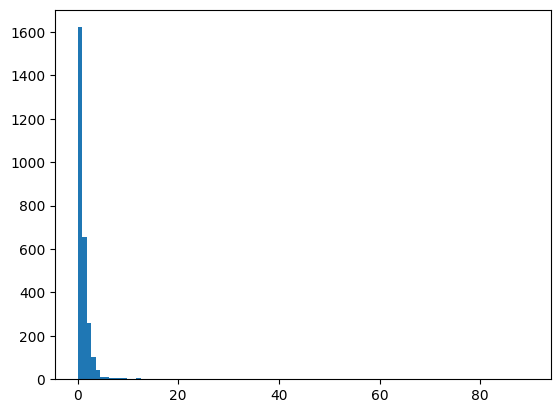

In [56]:
plt.hist(lost_money.wwgross_over_budget, bins = 100 );

In [ ]:
money_df = 